# Analysis of Facebook bid Data

This is a Python Project for analyzing the facebook data for their bidding site. In this Jupyter notebook I will examine the distribution the bidder, id and their url to examine if there correlation inside the data.

Data taken from https://www.kaggle.com/rafanovello/facebook-recruiting-bids 

Written by Shing Chi Leung at 14 March 2021

In [29]:
import pandas as pd
import numpy as np

# for classification
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import collections

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


In [3]:
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/facebook_bids.csv")

print("Header files = {}".format(df.head(5)))
print("Available columns = {}".format(df.columns))

Header files =    bid_id  ...              url
0       0  ...  vasstdc27m7nks3
1       1  ...  jmqlhflrzwuay9c
2       2  ...  vasstdc27m7nks3
3       3  ...  vasstdc27m7nks3
4       4  ...  vasstdc27m7nks3

[5 rows x 9 columns]
Available columns = Index(['bid_id', 'bidder_id', 'auction', 'merchandise', 'device', 'time',
       'country', 'ip', 'url'],
      dtype='object')


## Global Analysis of Data

In [4]:
country_list = df.country.unique()
country_size = []
for country in country_list:
  country_size.append((country, len(df[df["country"] == country])))

df_country_rank = pd.DataFrame(country_size, columns=["country", "users"])
print(df_country_rank)

    country   users
0        us   48285
1        in  278116
2        py    1479
3        ru   18153
4        th   26285
..      ...     ...
186      tl       2
187      pg       3
188      pf       1
189      vc       1
190      zz       1

[191 rows x 2 columns]


Text(0.5, 1.0, 'Number of users per country')

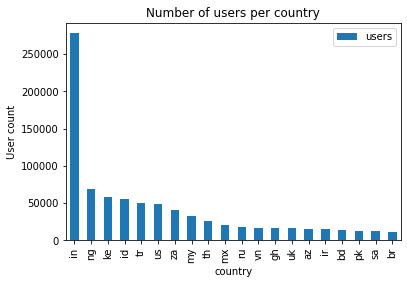

In [5]:
df_country_rank.sort_values("users", inplace=True, ascending=False)
ax = df_country_rank.head(20).plot.bar("country", "users")
ax.set_ylabel("User count")
ax.set_title("Number of users per country")

It shows that India has a very active use of Facebook bid. Its bidding count is 5 tmes more than most other countries. Then we take a look at the training data.

## Training and Test Data for Robotic Transaction

### Data Preparation

In [6]:
df_train = pd.read_csv("gdrive/MyDrive/Colab Notebooks/facebook_train.csv")
print("First few lines: {}".format(df_train))
print("Columnes include {}".format(df_train.columns))

First few lines:                                   bidder_id  ... outcome
0     91a3c57b13234af24875c56fb7e2b2f4rb56a  ...     0.0
1     624f258b49e77713fc34034560f93fb3hu3jo  ...     0.0
2     1c5f4fc669099bfbfac515cd26997bd12ruaj  ...     0.0
3     4bee9aba2abda51bf43d639013d6efe12iycd  ...     0.0
4     4ab12bc61c82ddd9c2d65e60555808acqgos1  ...     0.0
...                                     ...  ...     ...
2008  369515b3af4f8ca582f90271d30b14b6r52aw  ...     0.0
2009  f939c17ffc7c39ac9b35b69e5e75179fv9pe2  ...     0.0
2010  c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl  ...     0.0
2011  0381a69b7a061e9ace2798fd48f1f537mgq57  ...     0.0
2012  84a769adc98498f52debfe57b93a0789556f4  ...     0.0

[2013 rows x 4 columns]
Columnes include Index(['bidder_id', 'payment_account', 'address', 'outcome'], dtype='object')


Then I need to merge the training set with the database to form the informed database for the training. 

In [7]:
df_merge_train = df.merge(df_train, how="left", on="bidder_id")
df_merge_train.head(5)

df_merge_train.dropna(subset=["outcome"], inplace=True)
df_merge_train.dropna(subset=["country"], inplace=True)

Text(0, 0.5, 'count')

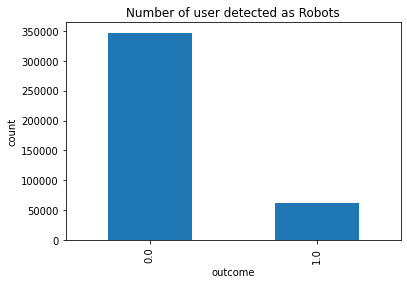

In [8]:
df_merge_train.head(5)

df_ratio = df_merge_train.groupby("outcome")["bid_id"].count()
ax2 = df_ratio.plot.bar()

ax2.set_title("Number of user detected as Robots")
ax2.set_ylabel("count")


Among all the 350k of transaction record, about 10% is classified as robots. 
Then we filter the training database for only useful variables. We choose the variables which reflect their transaction pattern. And we also relabel the data so that it can be used by the classification algorithm.

In [9]:
X = df_merge_train[["bidder_id", "address", "payment_account"]]

d = defaultdict(LabelEncoder)
X = X.apply(lambda x : d[x.name].fit_transform(x))
X.head()

,bidder_id,address,payment_account
1,324,177,573
5,682,201,71
9,504,465,269
10,504,465,269
13,387,746,696


Then we want to extract the independent and dependent variables in the test.

In [10]:
y = df_merge_train["outcome"].to_numpy()
print("The label array has a shape: {}".format(y.shape))

The label array has a shape: (408691,)


Then we split the data for training and testing the models.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Training the Random Forest Classifier

In [13]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[0.28339206 0.37826906 0.33833888]


(0.0, 0.4)

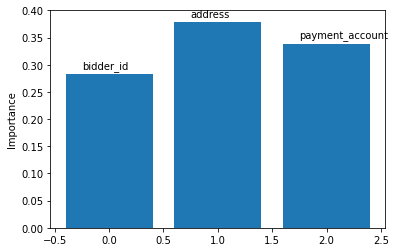

In [ ]:
print("The parameter importance are {}".format(rfc.feature_importances_))
fig3, ax3 = plt.subplots(nrows=1, ncols=1)
ax3.bar(range(3), rfc.feature_importances_)
ax3.set_title("Relative importance of user identifiable model.")

for i in range(3):
  ax3.annotate(X.columns[i], (i-0.25, rfc.feature_importances_[i] + 0.01))

ax3.set_ylabel("Importance")
ax3.set_xlabel("")
ax3.set_ylim(0, 0.4)

It suggests that the IP address will be the most identifiable feature for the bidding robot. Now we can proceed to test the model.

### Validating the Trained Classifier

In [16]:
y_pred = rfc.predict(X_test)



In [22]:
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n{}".format(conf_mat))

Confusion matrix: 
[[69283     0]
 [    0 12456]]


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     69283
         1.0       1.00      1.00      1.00     12456

    accuracy                           1.00     81739
   macro avg       1.00      1.00      1.00     81739
weighted avg       1.00      1.00      1.00     81739



This suggests that the identification based on these parameters can easily spot out the robotic bidding and transaction on Facebook Bids. 

### Checking the Geographic Distribution of Robotic Transaction

In [27]:
df_robots = df_merge_train[df_merge_train["outcome"] == 1]["country"]
print(df_robots)

20         hr
36         us
47         in
55         vn
107        uk
           ..
1048510    se
1048515    ru
1048526    se
1048557    in
1048572    ca
Name: country, Length: 61603, dtype: object


In [35]:
country_counter = pd.Series(collections.Counter(df_robots.to_numpy()))

Text(0, 0.5, 'Number')

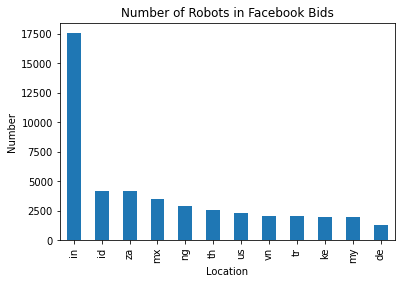

In [40]:
country_counter.sort_values(inplace=True, ascending=False)
ax4 = country_counter[country_counter > 1000].plot.bar()
ax4.set_title("Number of Robots in Facebook Bids")
ax4.set_xlabel("Location")
ax4.set_ylabel("Number")

Again this shows that the suspicious transaction in india is also dramatically higher, which is about five times to other countries in the list. And it contributes to about 5 - 10% of the overall transactions. 